### **🔹 Installation of Necessary Libraries and Tools**

**Purpose:** Before starting the text processing and clustering tasks, it's essential to install the necessary Python libraries. These libraries provide the tools required for various tasks such as text preprocessing, generating embeddings, reducing dimensions, clustering data, and visualizing the results.

- **NLTK:** For natural language processing tasks, including tokenization, stopword removal, and lemmatization.
- **Transformers and Torch:** To leverage BERT (Bidirectional Encoder Representations from Transformers) model, which is critical for generating high-quality embeddings that capture the semantic meaning of text.
- **Scikit-learn:** For machine learning tasks like scaling data, dimensionality reduction (PCA, t-SNE), and clustering (K-means).
- **Matplotlib and Seaborn:** For creating plots and visualizations, such as t-SNE scatter plots and silhouette scores.
- **WordCloud:** To generate word clouds that visually represent the frequency of words in each cluster.


In [ ]:
# Install required libraries
!pip install nltk transformers torch scikit-learn matplotlib seaborn wordcloud

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 23.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### **🔹 Imported Libraries and Tools**

**Purpose:** The code imports several key libraries necessary for the data processing and analysis pipeline:

- **Pandas and NumPy:** For efficient data manipulation and handling, especially when working with large datasets.
- **NLTK:** Used for text processing, such as removing stopwords and lemmatizing text, which standardizes words to their base forms.
- **Torch and Transformers:** Essential for loading the pre-trained BERT model and working with the high-dimensional embeddings it generates.
- **Scikit-learn:** Provides functions for preprocessing (StandardScaler), dimensionality reduction (PCA, t-SNE), and clustering (K-means), which are crucial steps in the analysis pipeline.
- **Matplotlib and Seaborn:** These libraries are used for visualizing data at different stages, helping in understanding the distribution and clustering of text data.
- **WordCloud:** This is used to create word clouds that help in interpreting the content of each cluster visually.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### **🔹 Loaded the Dataset**

**Purpose:** The dataset is loaded using Pandas, which allows for easy manipulation and preprocessing of data. The dataset is assumed to be in Parquet format, which is efficient for large-scale data storage and processing.

- **Loading the Dataset:** The `train.parquet` file is loaded into a Pandas DataFrame. This dataset likely contains a column of text data that will be preprocessed, embedded, and clustered.
  


In [ ]:
# Load dataset
train_file_path = '/kaggle/input/llm-data-for-clustring/train.parquet'
train = pd.read_parquet(train_file_path)

### **🔹 Created Function to Do Data Preprocessing**

**Purpose:** Preprocessing is a critical step in text analysis to clean and normalize the text data before further processing.

- **Cleaning the Text:** The `clean_text` function removes unnecessary characters (punctuation, numbers) and converts the text to lowercase, making the text uniform and easier to analyze.
- **Normalizing the Text:** The `normalize_text` function lemmatizes the words, converting them to their base forms. This step reduces redundancy by treating different forms of a word as a single entity.
- **Combining Steps:** The `preprocess_text` function combines cleaning and normalizing steps, making it easier to apply both transformations in a single step.


In [ ]:
# Define text preprocessing functions
def clean_text(text):
    """Remove punctuation, numbers, and stop words from the text."""
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    words = text.split()  # Split into words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)  # Rejoin the words

def normalize_text(text):
    """Normalize text using lemmatization."""
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

def preprocess_text(text):
    """Preprocess text by cleaning and normalizing."""
    text = clean_text(text)
    text = normalize_text(text)
    return text

### **🔹 Pre-Processed the Original Data**

**Purpose:** To prepare the dataset for embedding generation and clustering by applying the preprocessing functions defined earlier.

- **Subset of Data:** A subset of the data (e.g., the first 120,000 rows) is selected for processing to manage computational load and ensure efficient analysis.
- **Applying Preprocessing:** The text data is cleaned and normalized, and the processed text is stored in a new column. This processed text is what will be used for generating embeddings.


In [ ]:
# Define number of rows to process
num_rows = 120000  # Adjust this number as needed

# Limit the dataset to the first `num_rows` rows
train_subset = train.head(num_rows).copy()

# Apply preprocessing to the train data
train_subset['processed_text'] = train_subset['text'].apply(preprocess_text)

# Display some results
print("\nProcessed text dataset with clusters and indices:")
print(train_subset['processed_text'].head())


Processed text dataset with clusters and indices:
0    wall st bear claw back black reuters reuters s...
1    carlyle look toward commercial aerospace reute...
2    oil economy cloud stock outlook reuters reuter...
3    iraq halt oil export main southern pipeline re...
4    oil price soar alltime record posing new menac...
Name: processed_text, dtype: object


### **🔹 Loaded the Embeddings Generated by BERT Model**

**Purpose:** The embeddings generated by a pre-trained BERT model are loaded. These embeddings are high-dimensional vectors that capture the semantic meaning of the text.

- **BERT Embeddings:** BERT is a powerful language model that captures contextual information from text, making it ideal for tasks like clustering where semantic similarity is important.
- **Scaling the Embeddings:** Standardizing the embeddings using `StandardScaler` ensures that each feature contributes equally to the clustering process, preventing any single feature from dominating due to differences in scale.


In [ ]:

# Load precomputed embeddings
train_embeddings = np.load('/kaggle/input/llm-data-for-clustring/train_embeddings.npy')
train_embeddings = train_embeddings[:num_rows]  # Use the first `num_rows` embeddings

# Standardize the embeddings
scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)

### **🔹 Determined Optimal Number of Clusters**

**Purpose:** The optimal number of clusters is determined to ensure that the K-means algorithm can group the data effectively.

- **Silhouette Score:** This metric measures how similar each point in one cluster is to points in neighboring clusters. It helps in identifying the best number of clusters by maximizing the silhouette score.
- **Cluster Range:** A range of cluster numbers (e.g., 4 to 8) is tested to find the number of clusters that best separates the data.


In [ ]:
# Determine the optimal number of clusters using silhouette score
silhouette_scores = []
cluster_range = range(4, 8)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(train_embeddings_scaled)
    score = silhouette_score(train_embeddings_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {score}')

Number of clusters: 4, Silhouette Score: 0.06516973674297333
Number of clusters: 5, Silhouette Score: 0.054727569222450256
Number of clusters: 6, Silhouette Score: 0.05907108262181282
Number of clusters: 7, Silhouette Score: 0.054008081555366516


In [ ]:
# Find the optimal number of clusters (the one with the highest silhouette score)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {optimal_clusters}')

Optimal number of clusters: 4


### **🔹 Applied K-Means Clustering Algorithm**

**Purpose:** After determining the optimal number of clusters, the K-means algorithm is applied to group similar text embeddings together.

- **K-means Clustering:** This algorithm partitions the dataset into `k` clusters, where each data point belongs to the cluster with the nearest mean. It’s widely used due to its simplicity and efficiency in clustering large datasets.
- **Assigning Clusters:** The cluster labels are assigned to each data point, and these labels are stored in the DataFrame for further analysis.


In [ ]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(train_embeddings_scaled)

In [ ]:
# Add cluster labels and original indices to the DataFrame
train_subset['cluster'] = kmeans_labels
train_subset['original_index'] = train_subset.index

### **🔹 Dimensionality Reduction**

**Purpose:** Dimensionality reduction is applied to make the high-dimensional BERT embeddings more manageable and easier to visualize.

- **PCA (Principal Component Analysis):** PCA reduces the dimensionality of the embeddings while preserving as much variance as possible. Reducing to 50 components retains most of the essential information in the embeddings.
- **Why PCA?** PCA helps in simplifying the data, reducing noise, and making the data more suitable for subsequent steps like clustering and visualization.


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Reduce to 50 components
pca_result = pca.fit_transform(train_embeddings_scaled)


### **🔹 t-SNE for Further Dimensionality Reduction**

**Purpose:** t-SNE is used to further reduce the dimensions of the data for visualization purposes.

- **t-SNE (t-Distributed Stochastic Neighbor Embedding):** This technique reduces the data to 2 dimensions, which allows for effective visualization of clusters in a 2D plot.
- **Why t-SNE after PCA?** While PCA is effective for reducing dimensions and retaining variance, t-SNE excels at visualizing clusters by emphasizing local data structure, making it easier to see how the data points are grouped.


In [ ]:
# Apply t-SNE for further dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['Cluster'] = kmeans_labels


### **🔹 Plotted the t-SNE Visualization of Clusters**

**Purpose:** Visualizing the clusters using a t-SNE plot helps in assessing the quality of clustering and understanding the distribution of data points across clusters.

- **Scatter Plot:** The 2D t-SNE results are plotted, with each point colored according to its cluster label. This visual representation makes it easier to see how well the clustering algorithm has separated the data.
- **Why Visualization?** Visualization is crucial for interpreting the results of clustering, allowing for a qualitative assessment of how well the data has been grouped.


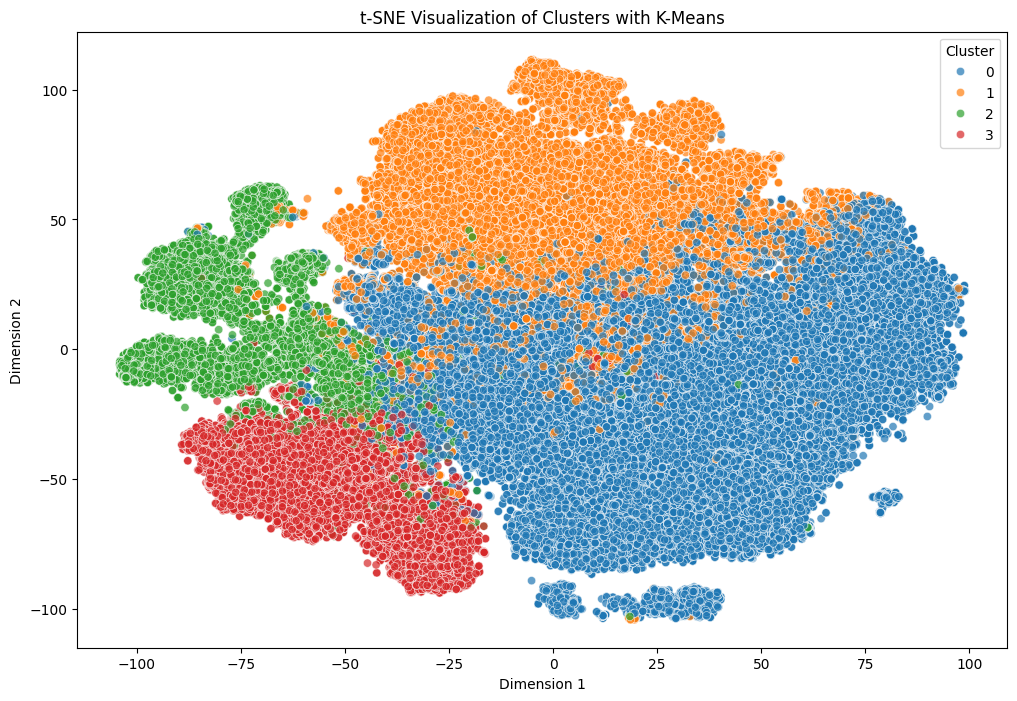

In [ ]:
# Plot t-SNE results
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Dim1', y='Dim2', hue='Cluster', data=tsne_df, palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Clusters with K-Means')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cluster')
plt.show()

### **🔹 Generated Word Clouds**

**Purpose:** Word clouds are generated to provide a visual summary of the most frequent words in each cluster, helping in the interpretation of what each cluster represents.

- **Word Cloud Generation:** For each cluster, a word cloud is generated based on the frequency of words in the processed text. This helps in quickly identifying the main themes or topics within each cluster.
- **Why Word Clouds?** Word clouds are an intuitive and visually appealing way to summarize the content of text data, making them useful for exploratory analysis and presenting results.


In [ ]:
# Function to generate and display word cloud for a given text
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

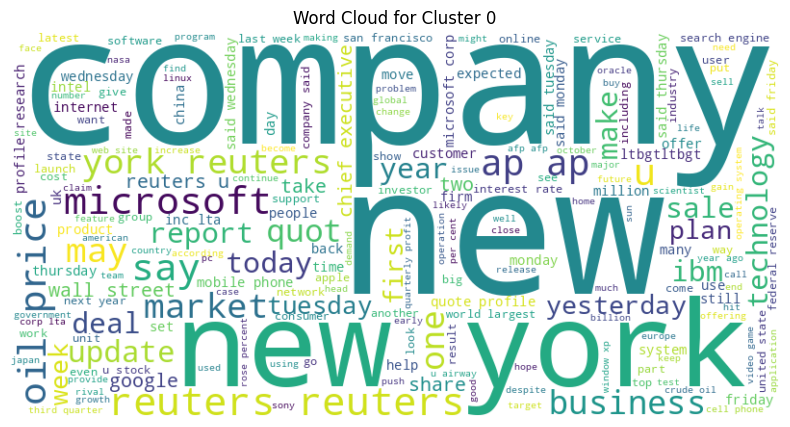

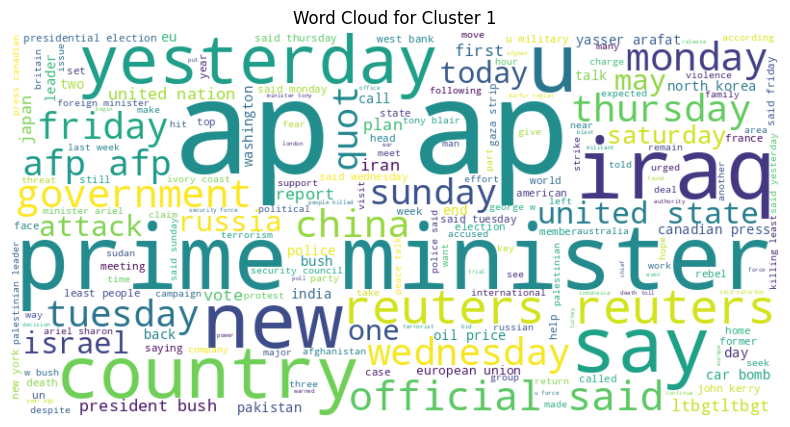

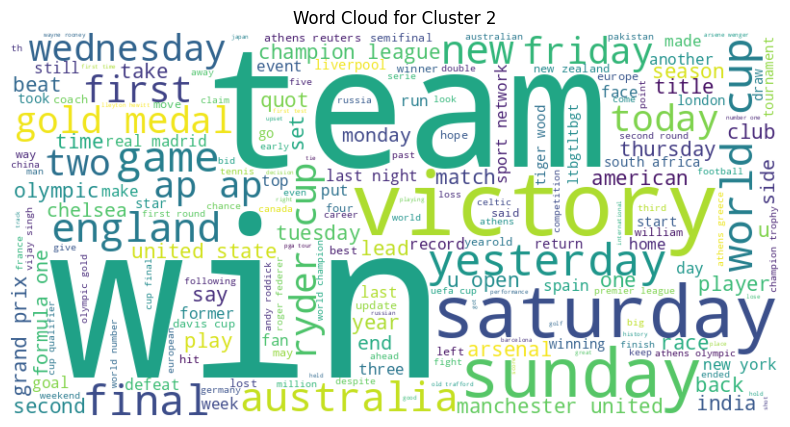

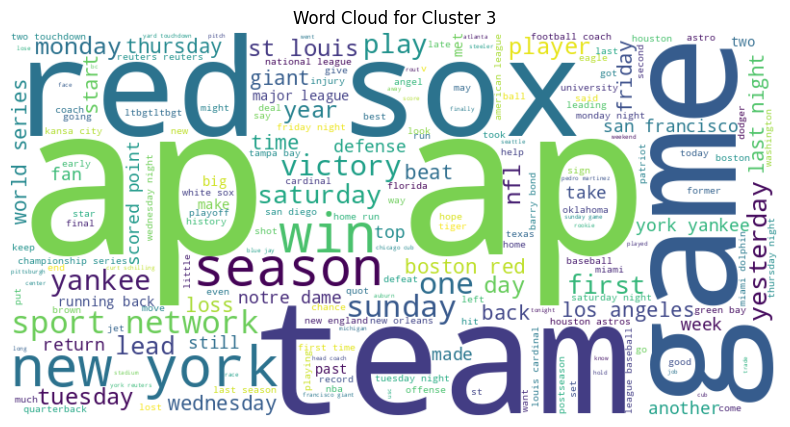

In [ ]:
# Generate and plot word clouds for each cluster
for cluster in range(optimal_clusters):
    cluster_texts = ' '.join(train_subset[train_subset['cluster'] == cluster]['processed_text'])
    plot_wordcloud(cluster_texts, f'Word Cloud for Cluster {cluster}')

In [ ]:
# Print clustering results
print(f"Number of clusters: {optimal_clusters}")

Number of clusters: 4



### **🔹 Printed Clustered Text**

**Purpose:** The clustered text is printed to provide concrete examples of the content in each cluster, aiding in understanding the nature of each group.

- **Cluster Details:** The number of texts in each cluster and sample texts are printed to give a sense of the diversity and content within each cluster.
- **Why Print Sample Texts?** By examining sample texts from each cluster, it’s easier to validate the results of clustering and to understand the characteristics that define each cluster.

In [ ]:
# Print details of each cluster
print("\nCluster Details:")
cluster_counts = train_subset['cluster'].value_counts()
for cluster_id, count in cluster_counts.items():
    print(f"\nCluster {cluster_id}:")
    print(f"Number of texts in cluster: {count}")
    sample_texts = train_subset[train_subset['cluster'] == cluster_id]['processed_text'].tolist()[:3]
    sample_indices = train_subset[train_subset['cluster'] == cluster_id]['original_index'].tolist()[:3]
    print("Sample texts from this cluster:")
    for text, index in zip(sample_texts, sample_indices):
        print(f"- Index: {index}, Text: {text}")


Cluster Details:

Cluster 0:
Number of texts in cluster: 58936
Sample texts from this cluster:
- Index: 0, Text: wall st bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green
- Index: 1, Text: carlyle look toward commercial aerospace reuters reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market
- Index: 2, Text: oil economy cloud stock outlook reuters reuters soaring crude price plus worriesabout economy outlook earnings expected tohang stock market next week depth thesummer doldrums

Cluster 1:
Number of texts in cluster: 31881
Sample texts from this cluster:
- Index: 3, Text: iraq halt oil export main southern pipeline reuters reuters authority halted oil exportflows main pipeline southern iraq afterintelligence showed rebel militia could strikeinfrastructure oil official said saturday
- Index: 11, Text: need opec pump more

In [ ]:
train_subset = train_subset[['text', 'processed_text']]

In [ ]:
# Display some results
print("\nProcessed text dataset with clusters and indices:")
print(train_subset.head())


Processed text dataset with clusters and indices:
                                                text  \
0  Wall St. Bears Claw Back Into the Black (Reute...   
1  Carlyle Looks Toward Commercial Aerospace (Reu...   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...   
3  Iraq Halts Oil Exports from Main Southern Pipe...   
4  Oil prices soar to all-time record, posing new...   

                                      processed_text  
0  wall st bear claw back black reuters reuters s...  
1  carlyle look toward commercial aerospace reute...  
2  oil economy cloud stock outlook reuters reuter...  
3  iraq halt oil export main southern pipeline re...  
4  oil price soar alltime record posing new menac...  
